<a href="https://colab.research.google.com/github/sreelakshmisatheesh/Mask_Detection_Hestia22/blob/main/Mask_Detection_Hestia_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/datasets/data.zip'

In [ ]:
!nvidia-smi

Fri May 13 16:13:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip uninstall numpy
!pip install tensorflow==2.4.0
!pip install tensorflow-gpu

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
NUM_CLASS = 3
class_names = ['face_with_mask_incorrect', 'face_with_mask_correct', 'face_no_mask']

LEARNING_RATE = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 224
dataset_path = "/content/data/MFN"
checkpoint_filepath = "checkpoint/epoch-{epoch:02d}-val_acc-{val_accuracy:.4f}.h5"
model_save_path = "model.h5"
figure_save_path = "figures/train_plot.jpg"

print("Num of classes: " + str(NUM_CLASS))
print("Classes: " + str(class_names))
print("Dataset path: " + dataset_path)
print("Checkpoint: " + checkpoint_filepath)
print("Figure save path: " + figure_save_path)

Num of classes: 3
Classes: ['face_with_mask_incorrect', 'face_with_mask_correct', 'face_no_mask']
Dataset path: /content/data/MFN
Checkpoint: checkpoint/epoch-{epoch:02d}-val_acc-{val_accuracy:.4f}.h5
Figure save path: figures/train_plot.jpg


In [ ]:
data_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input,
    validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    subset='training')

validation_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    subset='validation')

Found 160504 images belonging to 3 classes.
Found 40123 images belonging to 3 classes.


In [ ]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(NUM_CLASS, activation="softmax")(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
    layer.trainable = False

opt = Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True)


checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=False,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='auto')

In [ ]:
H = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    callbacks=[early_stopping, checkpoint],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=EPOCHS)

model.save(model_save_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
5015/5015 [==============================] - 2757s 546ms/step - loss: 0.1834 - accuracy: 0.9306 - val_loss: 0.0466 - val_accuracy: 0.9833
Epoch 2/20
5015/5015 [==============================] - 2602s 519ms/step - loss: 0.0528 - accuracy: 0.9815 - val_loss: 0.0339 - val_accuracy: 0.9878
Epoch 3/20
5015/5015 [==============================] - 2618s 522ms/step - loss: 0.0442 - accuracy: 0.9843 - val_loss: 0.0337 - val_accuracy: 0.9879
Epoch 4/20
1260/5015 [======>.......................] - ETA: 26:00 - loss: 0.0374 - accuracy: 0.9869

In [ ]:
prediction = model.predict_generator(
    generator=validation_generator,
    verbose=1)

y_pred = np.argmax(prediction, axis=1)
print(classification_report(validation_generator.classes, y_pred, target_names=class_names))

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(figure_save_path)

2.7.0


# Data Set

In [ ]:
shape = (150,150,3)
image_shape = (150,150)
batch_size=128
num_epochs = 10

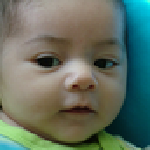

In [ ]:
img = load_img('/content/data/MFN/face_no_mask/00000.png',
                                            color_mode='rgb', 
                                            target_size=shape,
                                            interpolation='nearest')
img

In [ ]:
train_generator = image_dataset_from_directory(
    '/content/data/MFN/',
    image_size=image_shape,
    batch_size=batch_size,
    color_mode='rgb',
    # label_mode='binary',
    shuffle=True,
    subset='training',
    seed=123,
    validation_split=0.2
)

val_generator = image_dataset_from_directory(
    '/content/data/MFN/',
    image_size=image_shape,
    batch_size=batch_size,
    color_mode='rgb',
    # label_mode='binary',
    shuffle=True,
    subset='validation',
    seed=123,
    validation_split=0.2
)

Found 200627 files belonging to 3 classes.
Using 160502 files for training.
Found 200627 files belonging to 3 classes.
Using 40125 files for validation.


# Model Archtecture

In [ ]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

# Training

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

checkpoint_filepath = 'check_pt'

chk = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    callbacks=[es,chk],
    batch_size=batch_size
)

model.save('model.h5')

Epoch 1/10


AttributeError: ignored

In [ ]:
import os
a = "/content/drive/MyDrive/Mask/test"
path, dirs, files = next(os.walk(a))
file_count = len(files)
print(file_count)

In [ ]:
import os
a = "/content/drive/MyDrive/Mask/train/without_mask"
path, dirs, files = next(os.walk(a))
file_count = len(files)
print(file_count)

59141


In [ ]:
!cp -r '/content/drive/MyDrive/Mask/test/with_mask'

cp: missing destination file operand after '/content/drive/MyDrive/Mask/test/with_mask'
Try 'cp --help' for more information.


In [ ]:
!pip install models

ERROR: Could not find a version that satisfies the requirement models (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models


In [ ]:
!pip install models

  Using cached models-0.9.3.tar.gz (16 kB)
  Using cached models-0.9.2.tar.gz (16 kB)
  Using cached models-0.9.1.tar.gz (16 kB)
  Using cached models-0.9.0.tar.gz (14 kB)
  Using cached models-0.8.0.tar.gz (14 kB)
  Using cached models-0.7.0.tar.gz (14 kB)
  Using cached models-0.4.0.tar.gz (11 kB)
  Using cached models-0.3.0.tar.gz (11 kB)
  Using cached models-0.2.0.tar.gz (11 kB)
  Using cached models-0.1.1.tar.gz (11 kB)
  Using cached models-0.1.0.tar.gz (11 kB)
  Using cached models-0.0.5.tar.gz (6.4 kB)
  Using cached models-0.0.4.tar.gz (6.1 kB)
  Using cached models-0.0.3.tar.gz (6.2 kB)
ERROR: Could not find a version that satisfies the requirement models (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential 
import numpy as np
from glob import glob

In [ ]:
!pip install models
import models

  Using cached models-0.9.3.tar.gz (16 kB)
  Using cached models-0.9.2.tar.gz (16 kB)
  Using cached models-0.9.1.tar.gz (16 kB)
  Using cached models-0.9.0.tar.gz (14 kB)
  Using cached models-0.8.0.tar.gz (14 kB)
  Using cached models-0.7.0.tar.gz (14 kB)
  Using cached models-0.4.0.tar.gz (11 kB)
  Using cached models-0.3.0.tar.gz (11 kB)
  Using cached models-0.2.0.tar.gz (11 kB)
  Using cached models-0.1.1.tar.gz (11 kB)
  Using cached models-0.1.0.tar.gz (11 kB)
  Using cached models-0.0.5.tar.gz (6.4 kB)
  Using cached models-0.0.4.tar.gz (6.1 kB)
  Using cached models-0.0.3.tar.gz (6.2 kB)
ERROR: Could not find a version that satisfies the requirement models (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models


ModuleNotFoundError: ignored

In [ ]:
get_ipython().system('pip install models')

  Using cached models-0.9.3.tar.gz (16 kB)
  Using cached models-0.9.2.tar.gz (16 kB)
  Using cached models-0.9.1.tar.gz (16 kB)
  Using cached models-0.9.0.tar.gz (14 kB)
  Using cached models-0.8.0.tar.gz (14 kB)
  Using cached models-0.7.0.tar.gz (14 kB)
  Using cached models-0.4.0.tar.gz (11 kB)
  Using cached models-0.3.0.tar.gz (11 kB)
  Using cached models-0.2.0.tar.gz (11 kB)
  Using cached models-0.1.1.tar.gz (11 kB)
  Using cached models-0.1.0.tar.gz (11 kB)
  Using cached models-0.0.5.tar.gz (6.4 kB)
  Using cached models-0.0.4.tar.gz (6.1 kB)
  Using cached models-0.0.3.tar.gz (6.2 kB)
ERROR: Could not find a version that satisfies the requirement models (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models


In [ ]:
pip install --download=/tmp -r requirements.txt
pip install --user --no-index --find-links=/tmp -r requirements.txt

SyntaxError: ignored

In [ ]:
!pip install user <models>

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `pip install user <models>'


In [ ]:
pip install requirements.txt

ERROR: Could not find a version that satisfies the requirement requirements.txt (from versions: none)
ERROR: No matching distribution found for requirements.txt


In [ ]:
!pip install-upgrade pip

ERROR: unknown command "install-upgrade" - maybe you meant "install"


In [ ]:
!pip install google-colab

In [ ]:
!pip install upgrade

ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


In [ ]:
!pip install -q models

ERROR: Could not find a version that satisfies the requirement models (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models


In [ ]:
!python --version

Python 3.7.13


In [ ]:
!pip install models==0.9.3

  Using cached models-0.9.3.tar.gz (16 kB)
ERROR: Could not find a version that satisfies the requirement models==0.9.3 (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models==0.9.3


In [ ]:
!pip install models==0.9.2

  Using cached models-0.9.2.tar.gz (16 kB)
ERROR: Could not find a version that satisfies the requirement models==0.9.2 (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models==0.9.2


In [ ]:
!pip install models==0.9.1

  Using cached models-0.9.1.tar.gz (16 kB)
ERROR: Could not find a version that satisfies the requirement models==0.9.1 (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models==0.9.1


In [ ]:
!pip install models==0.9.1

  Using cached models-0.9.1.tar.gz (16 kB)
ERROR: Could not find a version that satisfies the requirement models==0.9.1 (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models==0.9.1


In [ ]:
!pip install InspectionV3

ERROR: Could not find a version that satisfies the requirement InspectionV3 (from versions: none)
ERROR: No matching distribution found for InspectionV3


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential 
import numpy as np
from glob import glob
from pyexpat import model

In [ ]:
IMAGE_SIZE=[224,224]
train_path='/content/drive/MyDrive/Mask/train'
valid_path='/content/drive/MyDrive/Mask/test'

In [ ]:
inception=InceptionV3(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inception.layers:
    layer.trainable=False

In [ ]:
folders=glob('/content/drive/MyDrive/Mask/train')

In [ ]:
x= Flatten()(inception.output)

prediction= Dense(len(folders),activation='softmax')(x)

In [ ]:
model = Model(inputs=inception.input, outputs=prediction)
model.summary()

NameError: ignored

In [ ]:
def result():
    global Model
    Model = Toplevel()

In [ ]:
model = Model(inputs=inception.input, outputs=prediction)

NameError: ignored

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen= ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen= ImageDataGenerator(rescale=1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Mask/train',target_size=(224,224),batch_size=32,class_mode='categorical')

Found 104720 images belonging to 2 classes.


In [ ]:
test_set=test_datagen.flow_from_directory('/content/drive/MyDrive/Mask/test',target_size=(224,224),batch_size=32,class_mode='categorical')

Found 194 images belonging to 2 classes.


In [ ]:
r=model.fit_generator( training_set, validation_data=test_set, epochs=10, steps_per_epoch=len(training_set), validation_steps=len(test_set))

NameError: ignored

In [ ]:
from tensorflow.keras import models

In [ ]:
r=models.fit_generator( training_set, validation_data=test_set, epochs=10, steps_per_epoch=len(training_set), validation_steps=len(test_set))

AttributeError: ignored

In [ ]:
from tensorflow.keras.models import fit_generator

ImportError: ignored

/content/drive/MyDrive/Mask/train


In [ ]:
r=model.fit( training_set, validation_data=test_set, epochs=10, steps_per_epoch=len(training_set), validation_steps=len(test_set))

NameError: ignored

In [ ]:
from tensorflow.keras import models

In [ ]:
from tensorflow.keras import fit

ImportError: ignored

In [ ]:
!pip install fit

  Created wheel for fit: filename=fit-0.4.1-py3-none-any.whl size=34785 sha256=92bffb1c020167788345db1273d06fb58100166718dbef4e3f07e282c8ab6efb
  Stored in directory: /root/.cache/pip/wheels/7a/18/4c/7a69135cc07ca296ef4fc5734cd9c3c7b84f1afc985724face
Successfully built fit


In [ ]:
!pip install fit_generator

ERROR: Could not find a version that satisfies the requirement fit_generator (from versions: none)
ERROR: No matching distribution found for fit_generator


In [ ]:
!pip install models

ERROR: Could not find a version that satisfies the requirement models (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models


In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation,Flatten,Reshape
from keras.layers.convolutional import Convolution1D,Convolution2D,MaxPooling2D
from keras.utiils import np_utiils

ModuleNotFoundError: ignored

In [ ]:
!apt install model

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package model
